In [25]:
# %matplotlib inline
%matplotlib qt  # wx, gtk, osx, tk, empty uses default

from math import floor
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

UsageError: unrecognized arguments: # wx, gtk, osx, tk, empty uses default

In [4]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [38]:
sample = random.sample(range(0, 19), 19)
rand_n_patients = [load_scan(INPUT_FOLDER + patients[s]) for s in sample]
n_patient_pixels = [get_pixels_hu(patient) for patient in rand_n_patients]

# for i, patient_pixels in enumerate(n_patient_pixels):
#     plt.hist(patient_pixels.flatten(), bins=80, color='c')
#     plt.xlabel("Hounsfield Units (HU)")
#     plt.ylabel("Frequency")
#     plt.show()
    
#     # Show some slice in the middle
#     plt.imshow(patient_pixels[80], cmap=plt.cm.gray)
#     plt.show()

    
# ax = plt.subplot(n, m, i) # or plt.subplot(nmi)
# ax11 = plt.subplot(2,2,1)
# ax21 = plt.subplot(2,2,2)
# ax12 = plt.subplot(2,2,3)
# ax22 = plt.subplot(2,2,4)

# fig, axes = plt.subplots(2,2)
# plot = axes.ravel()

# fig, ax = plt.subplots(2,2 figsize=(5,5)) #, subplot_kw=)
# ax[0,0]

## View sections for selection of patients

Current size: [15.0, 15.0]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


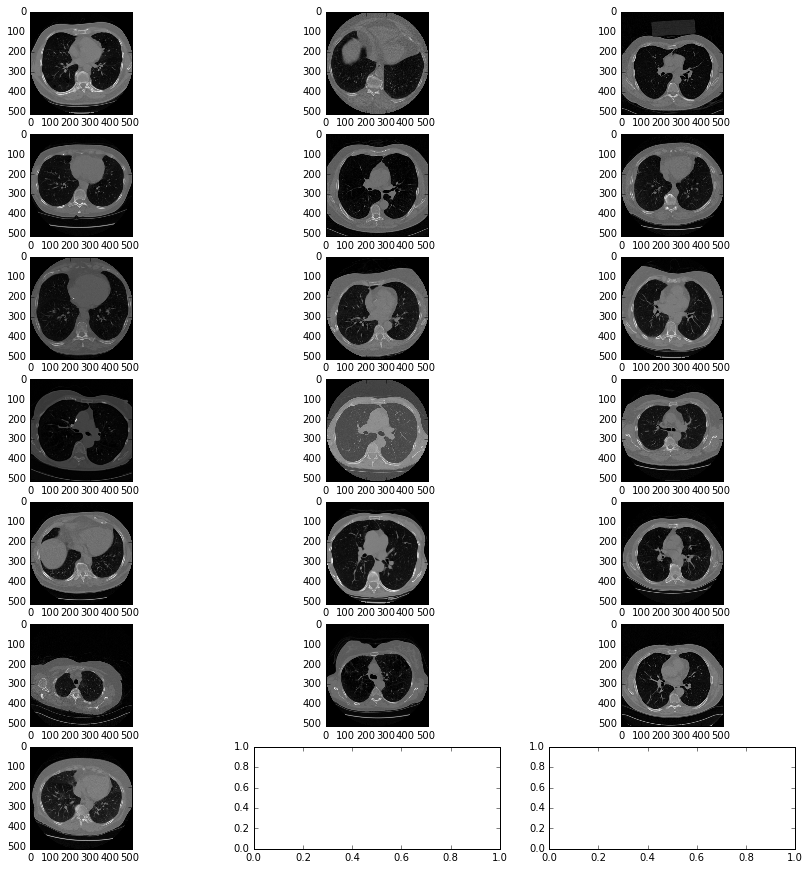

In [49]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print "Current size:", fig_size

# Set figure width and height
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

fig, axes = plt.subplots(7,3)
fig = plt.figure(figsize=(25,20))
for i, patient_pixels in enumerate(n_patient_pixels):
    axes[floor(i/3),i%3].imshow(patient_pixels[80], cmap=plt.cm.gray)    

## View slices for selected patient

In [ ]:
fig, axes = plt.subplots(30,30)

for i, patient_pixels in enumerate(n_patient_pixels[0]):
    axes[floor(i/3),i%3].imshow(n_patient_pixels[0][i], cmap=plt.cm.gray)  

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


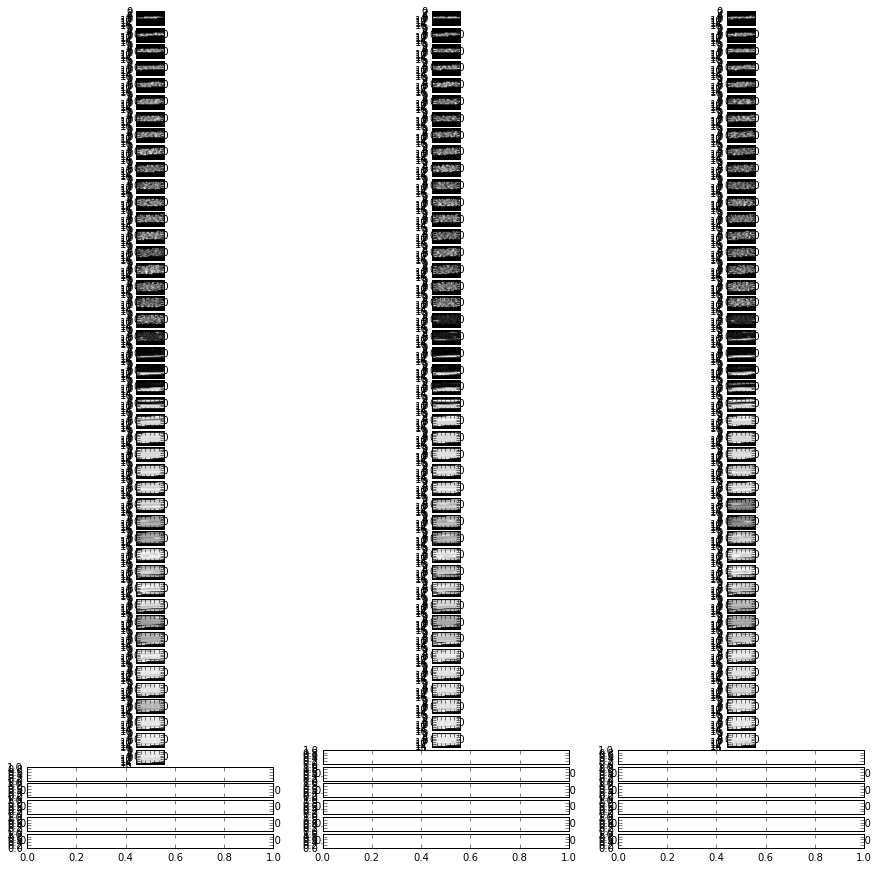

In [73]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width and height
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

fig, axes = plt.subplots(50,3) #,gridspec_kw={'width_ratios':[10, 10]})
# fig = plt.figure(figsize=(50,50))
for i, patient_pixels in enumerate(n_patient_pixels[0]):
#     print(type(patient_pixels[i]))
#     print(patient_pixels[i].reshape(16,32).shape)
    axes[floor(i/3),i%3].imshow(patient_pixels[i].reshape(16,32), cmap=plt.cm.gray)    

In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [8]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

('Shape before resampling\t', (134, 512, 512))
('Shape after resampling\t', (335, 306, 306))


In [14]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

<IPython.core.display.Javascript object>


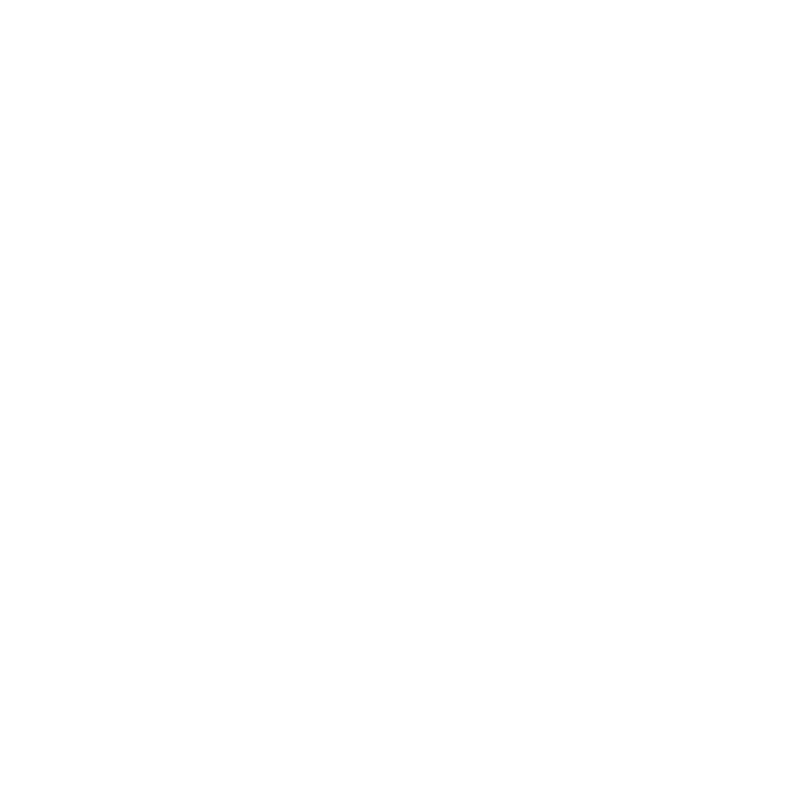

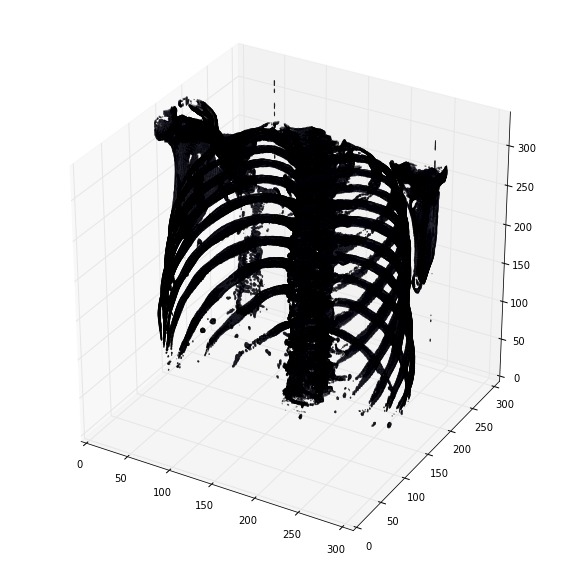

In [17]:
plot_3d(pix_resampled, 400)

In [11]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [12]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

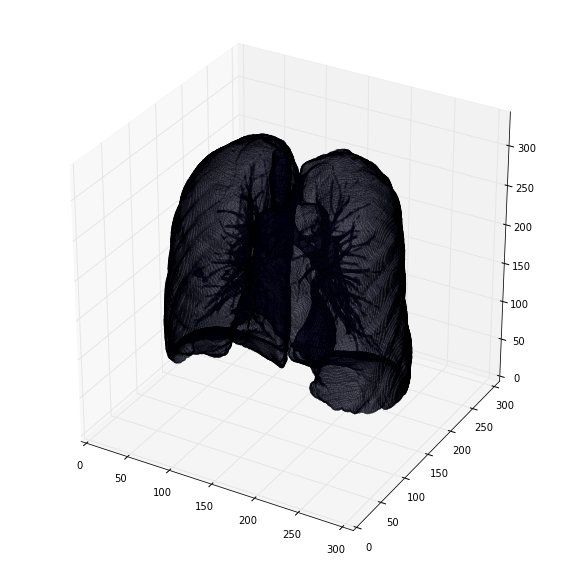

In [13]:
plot_3d(segmented_lungs, 0)

In [1]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

NameError: name 'plot_3d' is not defined